# Proyecto 10

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
from scipy.stats import ttest_ind

In [2]:
logs = pd.read_csv(
    './datasets/logs_exp_us.csv',
    engine='python',
    sep='\s+', 
    header=0,
    dtype={'EventName':'category', 'ExpId':'category'},
)

In [3]:
logs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


# Paso 2: Preparar los datos

In [4]:
#cambiamos los nombres a nombres mas descriptivos
logs.columns = ['event_name', 'user_id', 'full_date', 'experiment_group']

In [5]:
logs.head()

,event_name,user_id,full_date,experiment_group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# Corregimos tipo de datos
logs['full_date'] = logs['full_date'].apply(lambda x: pd.to_datetime(x, unit = 's'))

logs.head()

,event_name,user_id,full_date,experiment_group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [7]:
logs.isna().sum()

event_name          0
user_id             0
full_date           0
experiment_group    0
dtype: int64

In [8]:
logs.duplicated().sum()

413

In [9]:
duplicated_logs = logs[logs.duplicated()].sort_values(by=['event_name', 'user_id', 'full_date', 'experiment_group'])
duplicated_logs.query('user_id == 197027893265565660')

,event_name,user_id,full_date,experiment_group
17037,CartScreenAppear,197027893265565660,2019-08-01 11:40:14,246
23421,CartScreenAppear,197027893265565660,2019-08-01 14:15:28,246
34223,CartScreenAppear,197027893265565660,2019-08-01 18:35:44,246
112562,CartScreenAppear,197027893265565660,2019-08-04 07:15:04,246
144045,CartScreenAppear,197027893265565660,2019-08-05 05:44:20,246


In [10]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  category      
 1   user_id           244126 non-null  int64         
 2   full_date         244126 non-null  datetime64[ns]
 3   experiment_group  244126 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 4.2 MB


Revisamos que no existan usuarios que esten en más de un grupo

In [11]:
grupo_246 = logs.query('experiment_group == "246"')['user_id'].unique()
grupo_247 = logs.query('experiment_group == "247"')['user_id'].unique()

In [12]:
set(grupo_246).issubset(set(grupo_247))

False

In [13]:
logs['fecha'] = logs.full_date.dt.date
logs['hora'] = logs.full_date.dt.time

logs.head()

,event_name,user_id,full_date,experiment_group,fecha,hora
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [14]:
print(f"""
Fecha mínima: {logs["fecha"].min()}
Fecha máxima: {logs["fecha"].max()}
""")


Fecha mínima: 2019-07-25
Fecha máxima: 2019-08-07



<Axes: xlabel='fecha'>

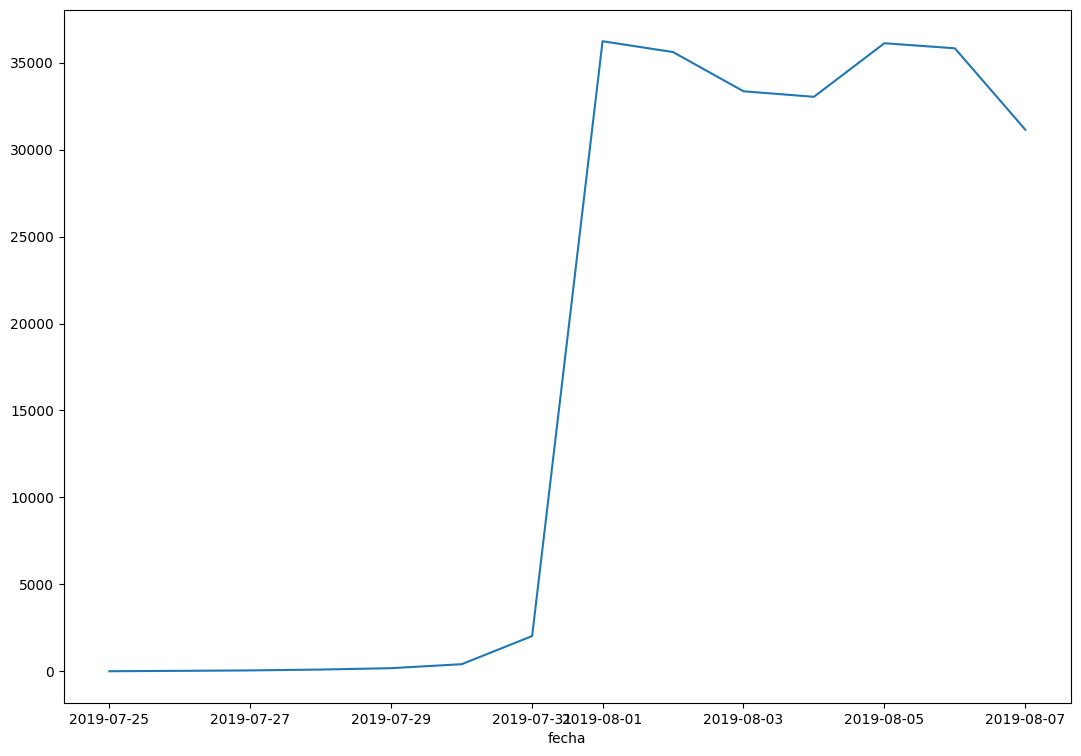

In [15]:
plt.figure(figsize = (13,9))
logs.groupby('fecha')['user_id'].count().plot()

In [16]:
logs_filtrados = logs[logs['fecha'] > pd.to_datetime("2019-07-31")]

C:\Users\franc\AppData\Local\Temp\ipykernel_7408\149614037.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  logs_filtrados = logs[logs['fecha'] > pd.to_datetime("2019-07-31")]


In [17]:
print(f"""
Fecha mínima: {logs_filtrados["fecha"].min()}
Fecha máxima: {logs_filtrados["fecha"].max()}
""")


Fecha mínima: 2019-08-01
Fecha máxima: 2019-08-07



In [18]:
logs_filtrados['user_id'].nunique() / logs['user_id'].nunique()

0.9977486425638988

In [19]:
logs_filtrados.groupby("event_name")['user_id'].count().sort_values(ascending = False)

event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: user_id, dtype: int64

In [20]:
logs_filtrados.groupby("event_name")['user_id'].nunique().sort_values(ascending = False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

In [21]:
users_by_event = logs_filtrados.groupby("event_name")["user_id"].nunique().sort_values(ascending=False).reset_index()
users_by_event["users_in_previous_step"] = users_by_event["user_id"].shift(1)
users_by_event["conversion_previous_step"] = users_by_event["user_id"] / users_by_event["users_in_previous_step"]
users_by_event["dropoff_rate"] = 1 - users_by_event["conversion_previous_step"]

users_by_event.head()

,event_name,user_id,users_in_previous_step,conversion_previous_step,dropoff_rate
0,MainScreenAppear,7419,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,0.619086,0.380914
2,CartScreenAppear,3734,4593.0,0.812976,0.187024
3,PaymentScreenSuccessful,3539,3734.0,0.947777,0.052223
4,Tutorial,840,3539.0,0.237355,0.762645


In [22]:
fig = go.Figure(go.Funnel(
    y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
    x = [7419, 4593, 3734, 3539],
    textinfo = "value+percent initial")
    )
fig.show()

In [23]:
logs_filtrados.groupby('experiment_group')['user_id'].nunique()

experiment_group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [24]:
conversion = logs_filtrados[['user_id','experiment_group']].drop_duplicates()
conversion

,user_id,experiment_group
2828,3737462046622621720,246
2832,1433840883824088890,247
2833,4899590676214355127,247
2840,1182179323890311443,246
2844,4613461174774205834,248
...,...,...
243339,5811573131275421338,248
243542,5365227480683749189,248
243777,6660805781687343085,246
243820,7823752606740475984,246


In [25]:
converted = pd.DataFrame(data= {
    "user_id": logs_filtrados[logs_filtrados['event_name'] == "PaymentScreenSuccessful"]['user_id'].unique(),
    "converted": 1
})


In [26]:
conversiones = conversion.merge(converted, on ="user_id", how = "left")
conversiones['converted'] = conversiones["converted"].fillna(0)
conversiones

,user_id,experiment_group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,0.0
7530,5365227480683749189,248,0.0
7531,6660805781687343085,246,0.0
7532,7823752606740475984,246,1.0


In [27]:
user_246 = conversiones[conversiones['experiment_group'] == "246"]['converted']
user_247 = conversiones[conversiones['experiment_group'] == "247"]['converted']

- H0: la tasa promedio de conversion entre el grupo 246 y 247 son iguales.
- H1: la tasa promedio de conversion entre los grupos 246 y 247 son distintas.

In [28]:
alpha = 0.1

_, p_valor = ttest_ind(user_246, user_247)
if (p_valor < alpha):
    print('Rechazar la hipótesis nula')
else:
    print('No se pudo rechazar la hipótesis nula')

No se pudo rechazar la hipótesis nula


# 5.4

- 248 (control) vs 247 -> por cada tipo de evento
- 248 vs 246 -> por cada tipo de evento
- 248 vs 246 + 247 -> por cada tipo de evento

# 5.5

In [29]:
n_pruebas = 12
significancia = 0.1

print("la probabilidad de un falso positivo es de: ", (1 - (1-significancia)**n_pruebas))

la probabilidad de un falso positivo es de:  0.7175704635189999


In [30]:
n_pruebas = 12
significancia = 0.01

print("la probabilidad de un falso positivo es de: ", (1 - (1-significancia)**n_pruebas))

la probabilidad de un falso positivo es de:  0.11361512828387077
